In [1]:
pip install tensorflow opencv-python matplotlib

  Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl.metadata (541 bytes)
Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.2
    Uninstalling protobuf-5.28.2:
      Successfully uninstalled protobuf-5.28.2
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.66.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.5 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications import vgg19
from tensorflow.keras import Model
import cv2

In [3]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = keras_image.load_img(img_path, target_size=target_size)
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

content_image_path = (r'C:\Users\ASUS\Downloads\content image.jpg')
style_image_path = (r'C:\Users\ASUS\Downloads\style image.jpg')

content_img = load_and_preprocess_image(content_image_path)
style_img = load_and_preprocess_image(style_image_path)


In [4]:
def get_model():
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False
    return vgg

model = get_model()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [5]:
content_layer = 'block5_conv2'  # Content Layer
style_layers = [
    'block1_conv1',  # Style Layer 1
    'block2_conv1',  # Style Layer 2
    'block3_conv1',  # Style Layer 3
    'block4_conv1',  # Style Layer 4
    'block5_conv1',  # Style Layer 5
]

def get_style_and_content_layers(model, style_layers, content_layer):
    content = model.get_layer(content_layer).output
    style = [model.get_layer(layer).output for layer in style_layers]
    return Model(inputs=model.input, outputs=[content] + style)

model = get_style_and_content_layers(model, style_layers, content_layer)

In [6]:
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, (-1, channels))
    return tf.matmul(a, a, transpose_a=True)

def style_loss(style, generated):
    return tf.reduce_mean(tf.square(gram_matrix(style) - gram_matrix(generated)))

def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

In [12]:
def compute_loss(generated_output, content, style):
    content_weight = 1e3
    style_weight = 1e-2
    c_loss = content_loss(content, generated_output[0])
    s_loss = sum(style_loss(style[i], generated_output[i + 1]) for i in range(len(style)))
    total_loss = content_weight * c_loss + style_weight * s_loss
    return total_loss

In [14]:
# Extract content and style features
content_features = model(content_img)
style_features = model(style_img)

# Save content feature and style features separately
content_feature = content_features[0]  # The first output is the content feature
style_feature = style_features[1:]      # The remaining outputs are the style features

In [15]:
@tf.function
def train_step(generated_image):
    with tf.GradientTape() as tape:
        outputs = model(generated_image)
        loss = compute_loss(outputs, content_feature, style_feature)  # Use pre-computed features
    gradients = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    return loss

In [16]:
# Extract content and style features
content_features = model(content_img)
style_features = model(style_img)

content_feature = content_features[0]  # Content feature
style_feature = style_features[1:]      # Style features

# Training Loop
epochs = 100
for i in range(epochs):
    loss = train_step(generated_image)  # Now using pre-computed features
    if i % 10 == 0:
        print(f"Epoch {i}, Loss: {loss.numpy()}")

Epoch 0, Loss: 7567631980691456.0
Epoch 10, Loss: 916802242609152.0
Epoch 20, Loss: 363412685062144.0
Epoch 30, Loss: 233522774147072.0
Epoch 40, Loss: 172253807378432.0
Epoch 50, Loss: 136377081528320.0
Epoch 60, Loss: 114488300797952.0
Epoch 70, Loss: 99522831187968.0
Epoch 80, Loss: 88341177434112.0
Epoch 90, Loss: 79605465612288.0


In [20]:
def deprocess_image(tensor):
    img = tensor.numpy().squeeze()  # Remove the batch dimension
    img = img.reshape((224, 224, 3))  # Reshape the image
    # Add the mean values to the image
    img[:, :, 0] += 103.939  # Red channel
    img[:, :, 1] += 116.779  # Green channel
    img[:, :, 2] += 123.68   # Blue channel
    img = np.clip(img, 0, 255).astype('uint8')  # Clip the values and convert to uint8
    return img

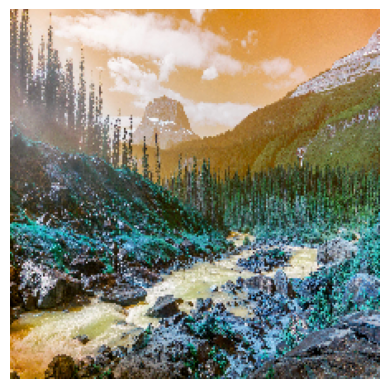

In [21]:
output_img = deprocess_image(generated_image)
plt.imshow(output_img)
plt.axis('off')
plt.show()

In [22]:
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))

True